In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize(128),   # smaller for speed
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

dataset = datasets.CIFAR10(root='./data', train=True,
                           transform=transform, download=True)
testset = datasets.CIFAR10(root='./data', train=False,
                           transform=transform, download=True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:21<00:00, 7.88MB/s]


In [ ]:
#model
model = models.densenet121(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.BatchNorm1d(model.classifier.in_features),
    nn.Linear(model.classifier.in_features, 10)
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 222MB/s]


In [ ]:
#training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

train_losses, val_losses = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(valloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")


Epoch 1: Train=0.5574, Val=0.4281
Epoch 2: Train=0.4463, Val=0.4020
Epoch 3: Train=0.4220, Val=0.4042
Epoch 4: Train=0.4163, Val=0.3990
Epoch 5: Train=0.4057, Val=0.3902


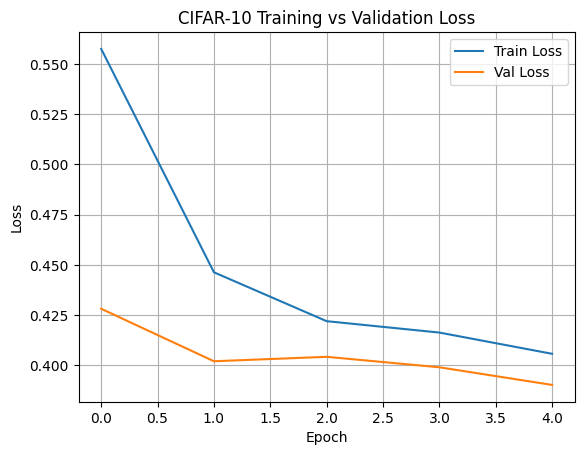

In [ ]:
#loss curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("CIFAR-10 Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


Test Accuracy: 86.77


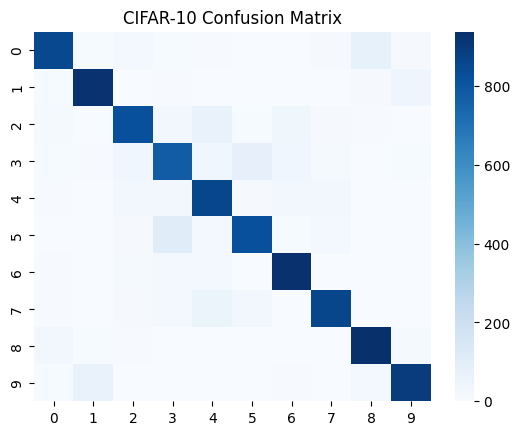

In [ ]:
#confusion matrix
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        y_true.extend(labels.cpu())
        y_pred.extend(preds.cpu())

print("Test Accuracy:", 100 * correct / total)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues")
plt.title("CIFAR-10 Confusion Matrix")
plt.show()
